In [61]:
import skimage.external.tifffile as tiff
import numpy as np
from skimage.filters import threshold_otsu, gaussian, sobel
from skimage.morphology import watershed
from skimage import measure, draw
from scipy import ndimage as ndi
from scipy import optimize
import matplotlib.pyplot as plt

In [2]:
testfile = "img/test_dapi_gm130_tgn46.tif"

In [3]:
with tiff.TiffFile(testfile) as tif:
    images = tif.asarray().astype(float)
    metadata = tif[0].tags

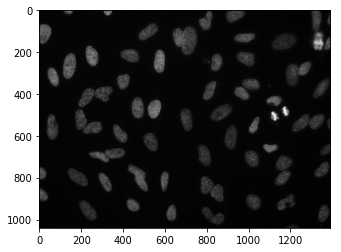

In [4]:
plt.imshow(images[0], cmap = "Greys_r")

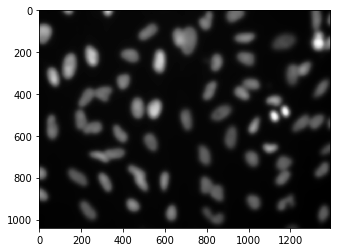

In [5]:
plt.imshow(gaussian(images[0], sigma=10), cmap = "Greys_r")

In [6]:
    img_gauss = gaussian(images[0], sigma = 3)
    thresh = threshold_otsu(img_gauss)
    binary = img_gauss > thresh
    contours = measure.find_contours(binary, 0.3)

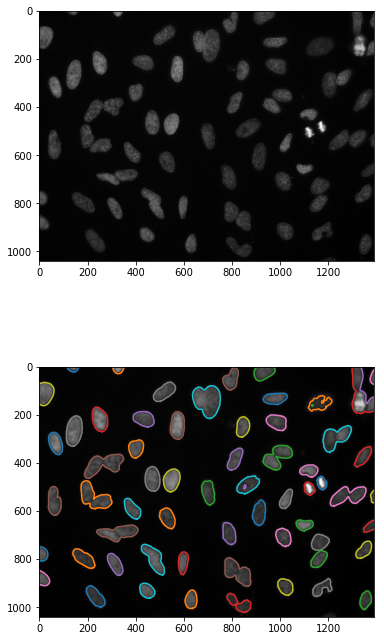

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (6,12))
ax1.imshow(images[0], cmap = "Greys_r")
ax2.imshow(img_gauss, cmap = "Greys_r")
for n, contour in enumerate(contours):
    ax2.plot(contour[:, 1], contour[:, 0])



In [8]:
markers = np.zeros_like(img_gauss)
markers[img_gauss < thresh] = 1
markers[img_gauss > thresh] = 2

In [9]:
elevation_map = sobel(img_gauss)

In [10]:
segmentation = watershed(elevation_map, markers)
segmentation = ndi.binary_fill_holes(segmentation - 1)

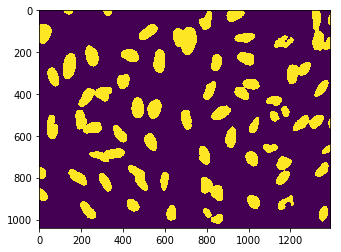

In [11]:
plt.imshow(segmentation)

In [12]:
labeled_nuclei, _ = ndi.label(segmentation)

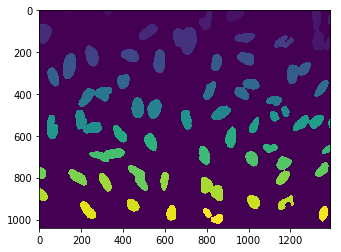

In [13]:
plt.imshow(labeled_nuclei)

In [14]:
np.unique(labeled_nuclei)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61])

In [15]:
labeled_nuclei.shape

(1040, 1392)

In [16]:
regions = measure.regionprops(labeled_nuclei)

In [17]:
pixel_per_micron = metadata['x_resolution'].value[0] / metadata['x_resolution'].value[1]

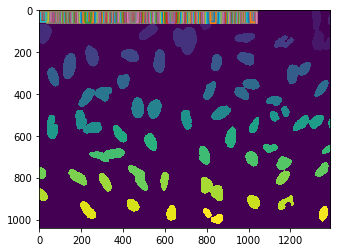

In [17]:
plt.imshow(labeled_nuclei)
perim = np.zeros_like(labeled_nuclei)
for props in regions:
    y0, x0 = props.centroid
    rr, cc = circle_perimeter(int(round(x0)), int(round(y0)), int(round(45 * pixel_per_micron)))
    rr[rr < 0] = 0
    rr[rr >= perim.shape[0]] = perim.shape[0] -1
    cc[cc < 0] = 0
    cc[cc >= perim.shape[1]] = perim.shape[1] -1
    perim[rr, cc] = props.label
    #print(cc)
    plt.plot(perim)

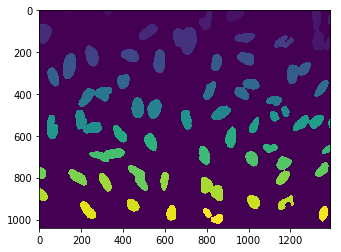

In [57]:
plt.imshow(labeled_nuclei)
perim = np.zeros_like(labeled_nuclei)

y0, x0 = regions[11].centroid
rr, cc = circle_perimeter(int(round(x0)), int(round(y0)), int(round(45 * pixel_per_micron)))
perim[rr,cc] = regions[11].label
plt.Circle(perim)

In [67]:
def cost(params):
    x0, y0, r = params
    coords = draw.circle(y0, x0, r, shape = labeled_nuclei.shape)
    template = np.zeros_like(labeled_nuclei)
    template[coords] = 1
    return -np.sum(template == labeled_nuclei)

In [59]:
r = 45 * pixel_per_micron

In [68]:
x0, y0, r = optimize.fmin(cost, (x0, y0, r))

Optimization terminated successfully.
         Current function value: -1199814.000000
         Iterations: 45
         Function evaluations: 127


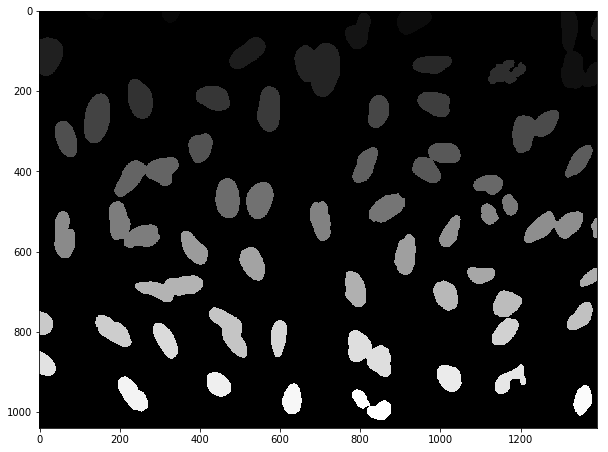

In [69]:
fig, ax = plt.subplots(figsize = (10,20))
circle = plt.Circle((x0, y0), r)
ax.imshow(labeled_nuclei, cmap="gray")
ax.add_artist(circle)
plt.show()

In [70]:
regions[11].centroid

(219.25987780040734, 251.3164969450102)

In [72]:
r

0.20697835239243242